# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import re

import collections
from collections import defaultdict
import gc

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
import sklearn
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.impute import SimpleImputer

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
print (sklearn.__version__)

0.23.1


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
imputer = SimpleImputer(missing_values = np.nan , strategy= 'most_frequent')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
# load in the data
azdias = pd.read_csv('./azdias.csv').drop(['Unnamed: 0'], axis=1)

C:\Users\bune1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [333]:
azdias.head()

In [8]:
azdias.shape

(891221, 366)

In [10]:
customers = pd.read_csv('./customers.csv').drop(['Unnamed: 0'], axis=1)

C:\Users\bune1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [334]:
customers.head()

In [12]:
customers.shape

(191652, 369)

# Handling Mixed attributes

In [13]:
"""
    A resuable function to get the categorical and numerical columns in a dataframe
"""

def get_nums_cats(df):
    all_columns = df.columns
    cat_columns = df.select_dtypes(include=['O']).columns
    num_columns = list(set(all_columns)-set(cat_columns))
    return num_columns, cat_columns

In [14]:
""" 
    Function to convert the given value into nan
"""

def convert_to(df, cols, elems, to_convert):
    
    if type(elems) == list:
    
        for i in df[cols].columns:
            for elem in elems:
                if elem in df[i].unique():
                    print("v"*40)
                    df[i].replace(elem, to_convert, inplace=True)
                    print("Done converting ----------- '" + str(elem) + "' as '"+ str(to_convert) +"' in " + i)
                    print("v"*40)
                    print()
                else:
                    print("x-"*40)
                    print(str(elem) + " not in "+ i)
                    print("x-"*40)
                    print()
    
    else:
        
        for i in df[cols].columns:
            if elems in df[i].unique():
                print("v"*40)
                df[i].replace(elems, to_convert, inplace=True)
                print("Done converting ----------- '" + str(elems) + "' as '"+ str(to_convert) +"' in " + i)
                print("v"*40)
                print()
            else:
                print("x-"*40)
                print(str(elems) + " not in "+ i)
                print("x-"*40)
                print()

In [15]:
az_num_columns, az_cats_columns = get_nums_cats(azdias)

all_az_col_list = azdias.columns

In [336]:
"""
    We can see there are mixed attributes which has Xs and XXs in it. We need to change it in proper format.
    For example in the customers categorical columns we can say and deduce that the 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015',
    and 'CAMEO_INTL_2015' has Xs and XXs values in it
"""
for col in az_cats_columns:
    print(col, azdias[col].unique())

In [337]:
elem_Xs = ['X', 'XX']
convert_to(azdias, az_cats_columns, elem_Xs, np.nan)

No more Xs and XXs in the 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015'. Let's convert the mixed columns into numeric datatype.

In [18]:
"""
    While loading the dataset we came accross an issue which shows the following:
        'Columns (18,19) have mixed types.'
    We'll fix this by converting those columns into numerical format
"""

az_mixed_attributes_lst = azdias.iloc[:,18:20].columns
az_mixed_attributes_lst

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [338]:
for i in az_mixed_attributes_lst:
    temp_cols = [i]
    for x in azdias[i].unique(): 
        if type(x) == str:
            convert_to(azdias, temp_cols, x, int(x))

In [20]:
for i in az_mixed_attributes_lst:
    temp_elem = []
    print(i)
    for x in azdias[i].unique():
        if type(x) == str:
            temp_elem.append(x)
    print(temp_elem)

CAMEO_DEUG_2015
[]
CAMEO_INTL_2015
[]


We have successfully converted the mixed attributes into numeric format.

# Reading the "Attributes" file to find unknowns

In [21]:
# Reading the 'Attributes file'
df_desc = pd.read_excel('./DIAS Attributes - Values 2017.xlsx',  skiprows=1).drop(['Unnamed: 0'], axis=1)
df_desc.ffill(axis = 0, inplace=True)
df_desc.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [22]:
# Function to get a list of unknowns and the values assigned to it
def get_unkown_list(df):
    # We'll check where the words unknown is used in the dataframe
    df_unkwn = df[((df['Meaning']).str.contains("unknown", na=False)) | ((df['Meaning']).str.contains("uniformly distributed", na=False))]
    
    # There are instances in the attributes dataset where we get values for unknown in the '1,0' format. Not exactly the same
    # but seperated by comma. So we'll seperate this into two dataframes so as to continue with our process.
    # Dataframe where there is comma not included
    df_unkwn_1_value = df_unkwn[~df_unkwn['Value'].str.contains(",", na=False)]
    # Dataframe where there is comma included
    df_unkwn_more_1_value = df_unkwn[df_unkwn['Value'].str.contains(",", na=False)]

    # We'll create an empty list to store key value pairs of column names as keys and unkown values assigned as values
    description_unkwn_1_value = defaultdict(list)

    # we'll use this to create just a dataframe of the 'Value' and 'Attribute' and zip it together
    for i, j in zip(df_unkwn_1_value.Value,df_unkwn_1_value.Attribute):
        description_unkwn_1_value[j].append(i)

    # Converting to a dictionary
    description_unkwn_1_value = dict(description_unkwn_1_value)

    # We'll use the pd.series to convert the dataframe which has unknown values seperated by commas to create a dictionary
    description_unkwn_more_1_value_test = pd.Series(df_unkwn_more_1_value.Value.values,index=df_unkwn_more_1_value.Attribute).to_dict()
    description_unkwn_more_1_value={}

    #Splitting the comma and appending it to a list
    for k,v in description_unkwn_more_1_value_test.items():
        temp = v.split(", ")
        temp = list(map(int, temp))
        if k in description_unkwn_1_value:
            a = description_unkwn_1_value.get(k)
            b = temp
            description_unkwn_1_value[k] = a+b
        else:
            description_unkwn_more_1_value[k] = temp

    # Merging the two dataframes
    unknown_dict = {**description_unkwn_1_value, **description_unkwn_more_1_value}
    
    #Sorting the dataframe
    unknown_dict = dict(collections.OrderedDict(sorted(unknown_dict.items())))

    return unknown_dict

In [23]:
description_unkwn = get_unkown_list(df_desc)

In [339]:
description_unkwn

# Handling missing data

In [25]:
# function to replace unknown values in each columns to nulls
def replace_unknown_to_nulls(df, column_list, unkwn_lst):
    for k,v in unkwn_lst.items():
        if k in column_list:
            temp_col = []
            temp_col.append(k)
            convert_to(df, temp_col, v, np.nan)
        else:
            print("Not present in the dataset: " + k+"\n")

#### Taking care of misspelled feature in 'azdias' and 'attributes'

In [26]:
cameo_az = azdias.columns[azdias.columns.str.contains("CAMEO")].tolist()
cameo_az.sort()
cameo_az

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

In [27]:
cameo_desc = df_desc[df_desc['Attribute'].str.match('CAMEO')]['Attribute'].unique()
cameo_desc.sort()
cameo_desc

array(['CAMEO_DEUG_2015', 'CAMEO_DEUINTL_2015', 'CAMEO_DEU_2015'],
      dtype=object)

In [28]:
azdias.rename(columns={'CAMEO_INTL_2015': 'CAMEO_DEUINTL_2015'}, inplace=True)

All set. We can remove the columns which which has a lot of missing values.

In [29]:
all_az_col_list = azdias.columns

In [340]:
replace_unknown_to_nulls(azdias, all_az_col_list, description_unkwn)

# Investigating how many columns to drop

In [31]:
percentage_bins = [0,10,20,30,40,50,60,70,80,90,100]

In [32]:
def percentage_nulls(bins, axis, df, axis_str):
    total_sides = df.shape[axis]
    
    if axis == 1:
        op_side = 0
    else:
        op_side = 1
        
    for i in bins:
        percent = i/100
        diff = total_sides - df.dropna(axis=axis, thresh=(1-percent)*df.shape[op_side]).shape[axis]
        print(str(diff) + " is the number of " + axis_str + " which has NaN entries more than or equal to " + str(i) + "% of total of " + str(total_sides) + " entries")

In [33]:
percentage_nulls(percentage_bins, 1, azdias, 'columns')

280 is the number of columns which has NaN entries more than or equal to 0% of total of 366 entries
245 is the number of columns which has NaN entries more than or equal to 10% of total of 366 entries
20 is the number of columns which has NaN entries more than or equal to 20% of total of 366 entries
10 is the number of columns which has NaN entries more than or equal to 30% of total of 366 entries
9 is the number of columns which has NaN entries more than or equal to 40% of total of 366 entries
9 is the number of columns which has NaN entries more than or equal to 50% of total of 366 entries
8 is the number of columns which has NaN entries more than or equal to 60% of total of 366 entries
7 is the number of columns which has NaN entries more than or equal to 70% of total of 366 entries
5 is the number of columns which has NaN entries more than or equal to 80% of total of 366 entries
5 is the number of columns which has NaN entries more than or equal to 90% of total of 366 entries
0 is 

In [35]:
percentage_nulls(percentage_bins, 0, azdias, 'rows')

891221 is the number of rows which has NaN entries more than or equal to 0% of total of 891221 entries
154646 is the number of rows which has NaN entries more than or equal to 10% of total of 891221 entries
132105 is the number of rows which has NaN entries more than or equal to 20% of total of 891221 entries
105811 is the number of rows which has NaN entries more than or equal to 30% of total of 891221 entries
100328 is the number of rows which has NaN entries more than or equal to 40% of total of 891221 entries
99968 is the number of rows which has NaN entries more than or equal to 50% of total of 891221 entries
93177 is the number of rows which has NaN entries more than or equal to 60% of total of 891221 entries
73517 is the number of rows which has NaN entries more than or equal to 70% of total of 891221 entries
0 is the number of rows which has NaN entries more than or equal to 80% of total of 891221 entries
0 is the number of rows which has NaN entries more than or equal to 90% o

In [36]:
"""
    Function to plot the null counts in the dataset
    df -> is the dataframe
    max_size -> is the percentage of null values
    axis -> is to choose the columns or rows; where 0 is for rows and 1 is for columns
"""

def plot_null_chart(df, max_size):
    percent = max_size/100

    null_columns = list(set(df.columns)-set(df.dropna(axis=1, thresh=np.int((1-percent)*(df.shape[0]))).columns))
    
    null_values = df[null_columns].isnull().sum().to_list()

    null_dict = {
        'columns':null_columns,
        'null_count':null_values
    }

    df_null = pd.DataFrame(null_dict)
    df_null = df_null.sort_values(by='null_count', ascending=False)    

    plot_line_msng_percent = range(10,101,10)

    df_null.plot(x='columns', y='null_count', kind='bar', figsize=(20,7), fontsize=13)
    
    title = 'List of columns which has Nan entries with atleast '+ str(max_size) + '% of total shape'
    plt.title(title)

    plt.show()

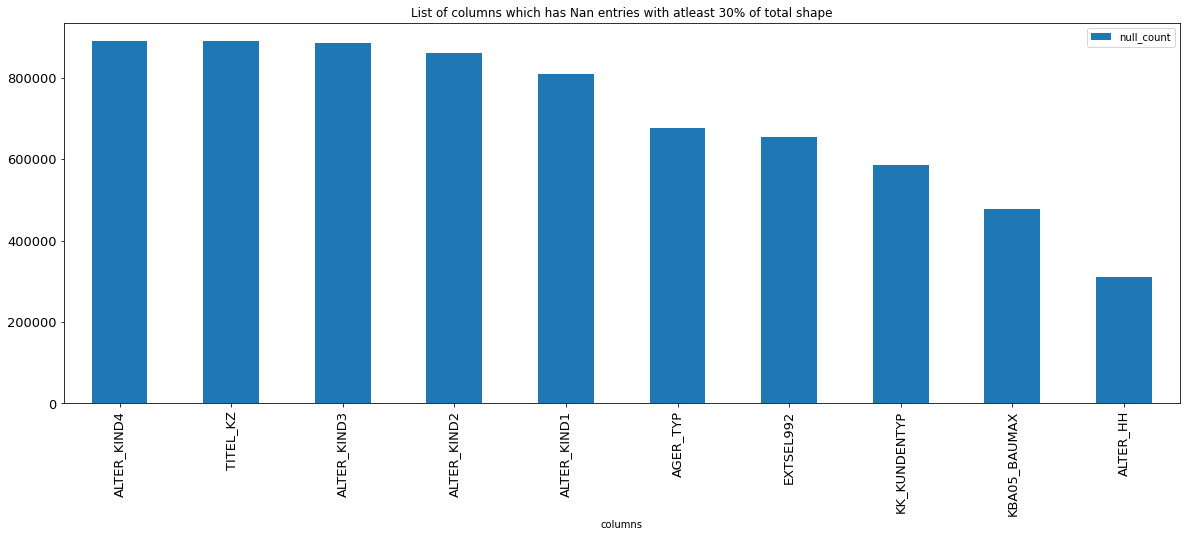

In [37]:
plot_null_chart(azdias, 30)

In [39]:
"""
    We'll create a function to get a dataframe of null values with there counts and
    feature names and bin them in another column
"""

def  get_null_dict(df, n, ax_shape, side):
    # dictionary of null counts in a sorted order
    print("Getting null counts and converting into dictionary.")
    null_row_dict = df.isnull().sum(axis=ax_shape).sort_values(ascending=False).to_dict()
    
    # An empty dictionary which has 'columns' which represents the features name, 
    # 'null_count' which is the total number of nulls in the feature
    # 'percentage' which is the percentage of nulls in a feature column
    print("Creating empty dictionary.")
    data_null = {
        side:[],
        'null_count':[],
        'percentage': []
    }

    print("Iterating through null_dictionary and appending into the empty dictionary")
    for k,v in null_row_dict.items():
        data_null[side].append(k)
        data_null['null_count'].append(v)
        percent = (v/df.shape[ax_shape])*100
        data_null['percentage'].append(round(percent,2))

    print("Creating empty dictionary")
    df_null = pd.DataFrame(data_null)

    print("Binning started")
    df_null['binned'] = pd.cut(df_null['percentage'], bins=n, labels=n[:-1])
    df_null['binned'].fillna(0, inplace=True)
    
    print()

    return df_null

In [40]:
"""
    Function to plot the null counts in the dataset
"""

def plot_complete_null_chart(df, df_null, max_size):
    if max_size <= df_null.shape[0]:
        df_null = df_null.iloc[:max_size, :]

        plot_line_msng_percent = range(10,101,10)

        df_null.plot(x='columns', y='null_count', kind='bar', figsize=(20,7), fontsize=13)

        for percnt in plot_line_msng_percent:

            percent_number = (percnt*df.shape[0])/100

            horiz_line_data = np.array([percent_number for i in range(max_size+1)])
            plt.plot(horiz_line_data, alpha=0.7)


        plt.show()
    
    else:
        print("Change the max_size value")

In [41]:
az_null_col_df = get_null_dict(azdias, percentage_bins, 0, 'columns')

Getting null counts and converting into dictionary.
Creating empty dictionary.
Iterating through null_dictionary and appending into the empty dictionary
Creating empty dictionary
Binning started



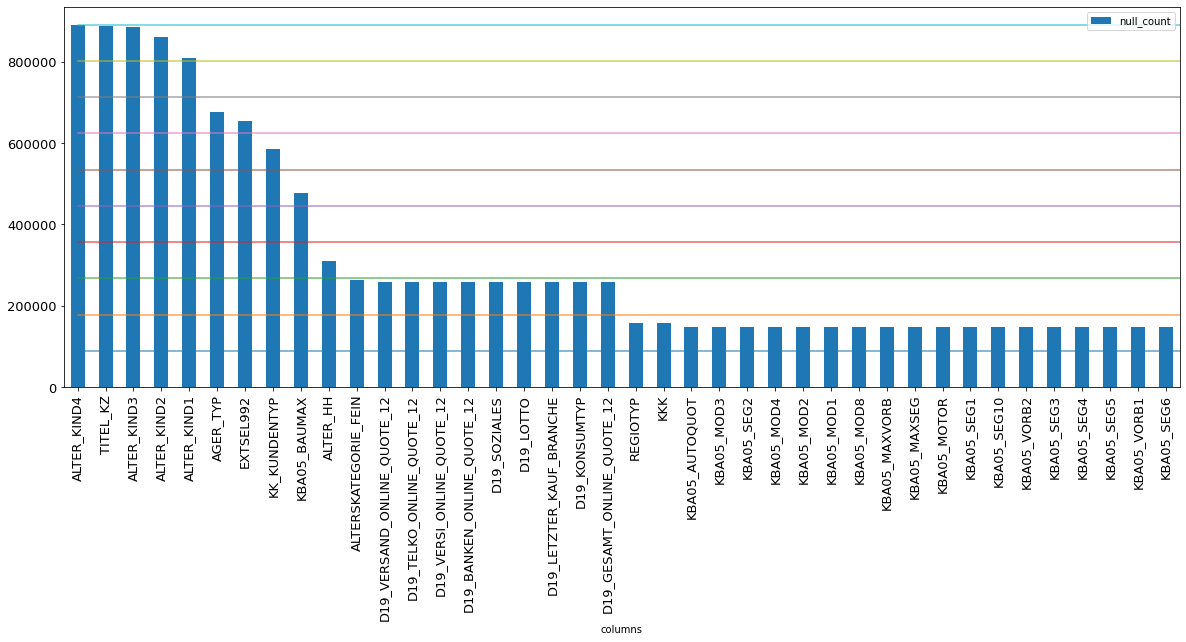

In [42]:
# second arguement is to get the number of elements we want in the x-axis
plot_complete_null_chart(azdias, az_null_col_df, 40)

### After checking the number of features that are required to be dropped, choosing 30% seems the best option

In [43]:
azdias.shape

(891221, 366)

In [44]:
should_del_per = 30
percent = should_del_per/100
azdias.dropna(axis=1, thresh=np.int((1-percent)*(azdias.shape[0])), inplace=True)

In [45]:
azdias.drop(['REGIOTYP', 'KKK'], axis=1, inplace=True)

In [46]:
azdias.shape

(891221, 354)

## Investigating other features

In [47]:
to_be_removed = []

In [48]:
az_num_columns, az_cats_columns = get_nums_cats(azdias)

all_az_col_list = azdias.columns

In [341]:
for i in az_cats_columns:
    print(i)
    print(azdias[i].value_counts(dropna=False))
    print()

In [50]:
"""
Converting 'CAMEO_DEU_2015' using label encoder
"""
int_encoder = LabelEncoder().fit_transform(azdias['CAMEO_DEU_2015'].values.tolist())
azdias['CAMEO_DEU_2015'] = int_encoder

In [51]:
"""
We can see that 'D19_LETZTER_KAUF_BRANCHE' is a column which has values representing different columns.
We might not need this and let's remove this out for the time being.
"""
to_be_removed.append('D19_LETZTER_KAUF_BRANCHE')

In [52]:
"""
'EINGEFUEGT_AM' is a column that has a lot of dates. We can either drop this column or extract the year and check if the
model performs better.

Converting this column into datetime and extracting year.
"""

azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S').dt.year

In [342]:
azdias['EINGEFUEGT_AM'].value_counts()

In [54]:
"""
Feature 'OST_WEST_KZ' has binary values in the format 'W', 'O'. We'll change this into 'W'->0 and 'O'->1
"""

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace(['W','O'],[0,1])

In [343]:
azdias['OST_WEST_KZ'].value_counts()

There are few features in the dataset that has a lot of unique values. It would be better to bin them and perform modelling.

In [344]:
for col in azdias.columns:
    print(col, len(azdias[col].unique()))

In [57]:
def change_feat_bin(num, range_num, min_entry, max_entry):
    
    max_roundUp = int(math.ceil(max_entry / float(range_num))) * range_num
    min_roundDown = int(math.floor(min_entry / float(range_num))) * range_num
    
    bins = list(range(min_roundDown, max_roundUp+1, range_num))
    labels = list(range(1, len(bins)))    
    
    if not np.isnan(num):
        for i in range(1, len(bins)):
            if num <= bins[i]:
                return labels[i-1]
    else:
        return np.nan

In [58]:
def recode_manual(df, col, bin_number):
    recode_str = col+'_recode'
    
    min_val = df[col].min()
    max_val = df[col].max()
    
    df[recode_str] = df[col].apply(lambda num : change_feat_bin(num, bin_number, min_val, max_val))
    
    return

In [59]:
to_be_removed.append('ANZ_HAUSHALTE_AKTIV')

min_val = azdias['ANZ_HAUSHALTE_AKTIV'].min()
max_val = azdias['ANZ_HAUSHALTE_AKTIV'].max()

azdias['ANZ_HAUSHALTE_AKTIV_recode'] = azdias['ANZ_HAUSHALTE_AKTIV'].apply(lambda num : change_feat_bin(num, 50, min_val, max_val))

In [60]:
to_be_removed.append('ANZ_STATISTISCHE_HAUSHALTE')

min_val = azdias['ANZ_STATISTISCHE_HAUSHALTE'].min()
max_val = azdias['ANZ_STATISTISCHE_HAUSHALTE'].max()

azdias['ANZ_STATISTISCHE_HAUSHALTE_recode'] = azdias['ANZ_STATISTISCHE_HAUSHALTE'].apply(lambda num : change_feat_bin(num, 100, min_val, max_val))

In [61]:
"""
    Since GEBURTSJAHR has a 0s as the year value, we can convert the 0s to null or drop the column.
"""

to_be_removed.append('GEBURTSJAHR')

azdias['GEBURTSJAHR_recode'] = azdias['GEBURTSJAHR'].replace(0, np.nan)
min_val = azdias['GEBURTSJAHR_recode'].min()
max_val = azdias['GEBURTSJAHR_recode'].max()

azdias['GEBURTSJAHR_recode'] = azdias['GEBURTSJAHR_recode'].apply(lambda num : change_feat_bin(num, 10, min_val, max_val))
azdias['GEBURTSJAHR_recode'].replace(np.nan, 0, inplace=True)

In [62]:
to_be_removed.append('KBA13_ANZAHL_PKW')

min_val = azdias['KBA13_ANZAHL_PKW'].min()
max_val = azdias['KBA13_ANZAHL_PKW'].max()

azdias['KBA13_ANZAHL_PKW_recode'] = azdias['KBA13_ANZAHL_PKW'].apply(lambda num : change_feat_bin(num, 100, min_val, max_val))

In [63]:
#---------------------------------------------------------------------------------------------------------------

In [64]:
to_be_removed.append('MIN_GEBAEUDEJAHR')

min_val = azdias['MIN_GEBAEUDEJAHR'].min()
max_val = azdias['MIN_GEBAEUDEJAHR'].max()

azdias['MIN_GEBAEUDEJAHR_recode'] = azdias['MIN_GEBAEUDEJAHR'].apply(lambda num : change_feat_bin(num, 5, min_val, max_val))

In [65]:
to_be_removed.append('VERDICHTUNGSRAUM')

min_val = azdias['VERDICHTUNGSRAUM'].min()
max_val = azdias['VERDICHTUNGSRAUM'].max()

azdias['VERDICHTUNGSRAUM_recode'] = azdias['VERDICHTUNGSRAUM'].apply(lambda num : change_feat_bin(num, 5, min_val, max_val))

We have some duplicate features which are:

    'LP_STATUS_GROB','LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB','ALTERSKATEGORIE_GROB' 
    
and they match with
    
    'LP_STATUS_FIEN','LP_FAMILIE_FIEN','LP_LEBENSPHASE_FIEN','ALTERSKATEGORIE_FIEN'
    
respectively

In [66]:
_grob = azdias.columns[azdias.columns.str.endswith("_GROB")]

In [67]:
_fein = azdias.columns[azdias.columns.str.endswith("_FEIN")]

In [68]:
same_columns = []

In [69]:
for i in _grob:
    for j in _fein:
        if i[:-4] == j[:-4]:
            same_columns.append([i,j])

In [70]:
same_columns

[['LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN'],
 ['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'],
 ['LP_STATUS_GROB', 'LP_STATUS_FEIN'],
 ['ALTERSKATEGORIE_GROB', 'ALTERSKATEGORIE_FEIN']]

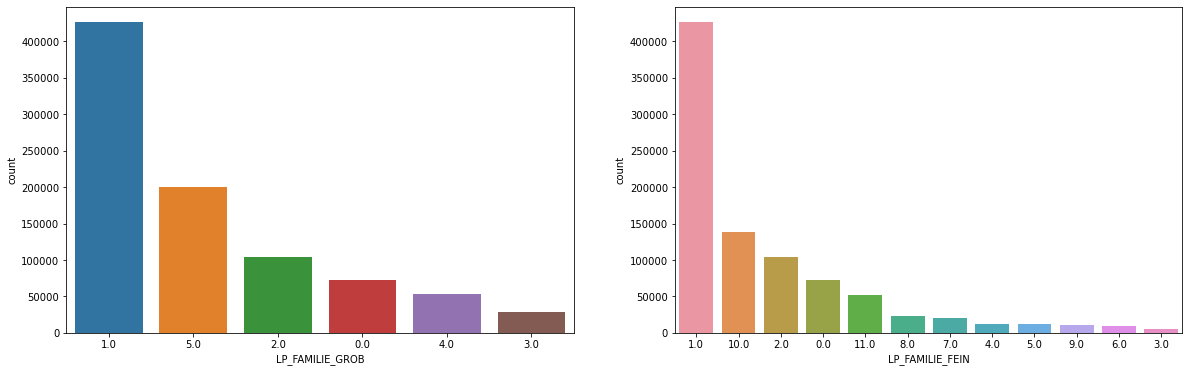

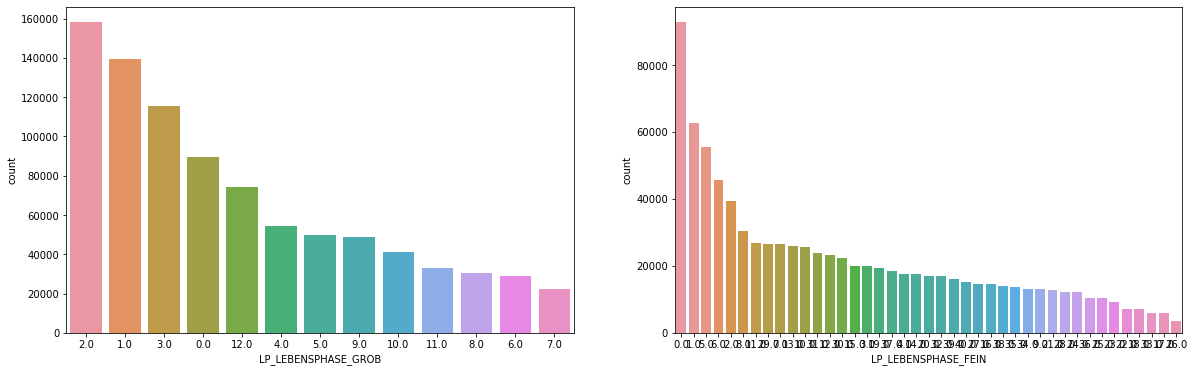

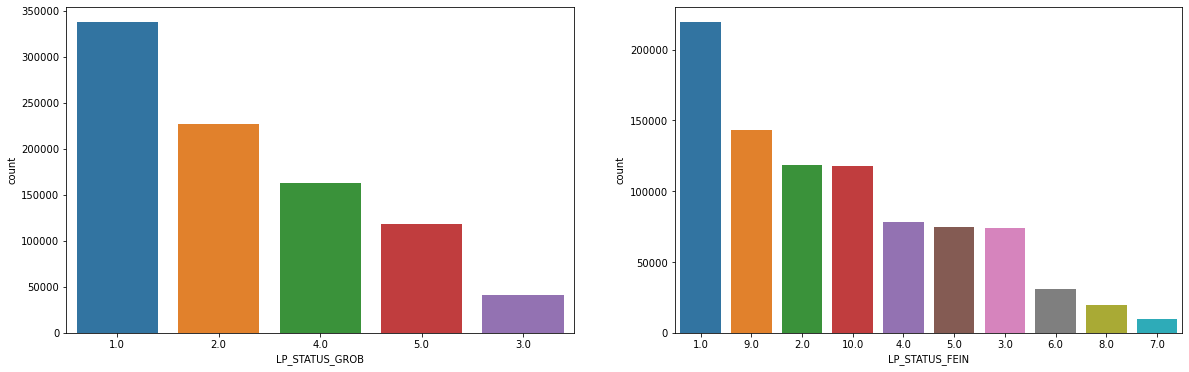

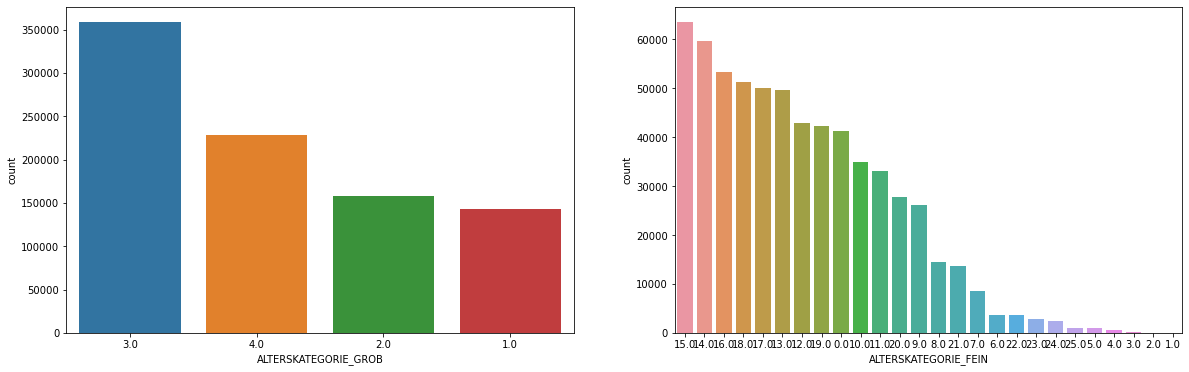

In [71]:
for group in same_columns:
    
    fig = plt.figure(figsize=(20, 6))
    
    ax1 = fig.add_subplot(121)
    sns.countplot(azdias[group[0]],order=azdias[group[0]].value_counts().index)

    ax2 = fig.add_subplot(122)
    sns.countplot(azdias[group[1]],order=azdias[group[1]].value_counts().index)

    plt.show()

As we can see the FIEN values have more categories than the GROB features. We'll drop the GROB features

In [345]:
to_be_removed = list(to_be_removed) + list(_grob)
# to_be_removed

### Formating the PRAEGENDE_JUGENDJAHRE into two different features.


In [73]:
df_desc_pj = df_desc[df_desc['Attribute'] == 'PRAEGENDE_JUGENDJAHRE'].copy()
df_desc_pj['Num_Extract'] = df_desc_pj['Meaning'].str.extract('(\d+)')
df_desc_pj["Num_Extract"] = pd.to_numeric(df_desc_pj["Num_Extract"])

word_list = ['Mainstream', 'Avantgarde']
df_desc_pj['Word_Extract'] = df_desc_pj['Meaning'].str.extract('({})'.format('|'.join(word_list)), 
                        flags=re.IGNORECASE, expand=False).str.lower().fillna('')

age_dict = df_desc_pj.iloc[1:, :].set_index('Value')['Num_Extract'].to_dict()
pj_word_dict = df_desc_pj.iloc[1:, :].set_index('Value')['Word_Extract'].to_dict()

In [74]:
to_be_removed.append('PRAEGENDE_JUGENDJAHRE')
azdias['PRAEGENDE_JUGENDJAHRE_age_recode'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(age_dict)
azdias['PRAEGENDE_JUGENDJAHRE_word_recode'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(pj_word_dict)

In [75]:
min_val = azdias['PRAEGENDE_JUGENDJAHRE_age_recode'].min()
max_val = azdias['PRAEGENDE_JUGENDJAHRE_age_recode'].max()

azdias['PRAEGENDE_JUGENDJAHRE_age_recode'] = azdias['PRAEGENDE_JUGENDJAHRE_age_recode'].apply(lambda num : change_feat_bin(num, 10, min_val, max_val))

In [76]:
azdias['PRAEGENDE_JUGENDJAHRE_word_recode']
int_encoder = LabelEncoder().fit_transform(azdias['PRAEGENDE_JUGENDJAHRE_word_recode'].values.tolist())
azdias['PRAEGENDE_JUGENDJAHRE_word_recode'] = int_encoder

We have tried to bin a lot of features. 

In [77]:
az_num_columns, az_cats_columns = get_nums_cats(azdias)

all_az_col_list = azdias.columns

In [78]:
azdias.drop(list(set(to_be_removed)), axis=1, inplace=True)

In [79]:
azdias.shape

(891221, 351)

### Imputing the dataset with the most-frequent value

In [80]:
gc.collect()

32811

In [81]:
azdias.drop(['LNR'], axis=1, inplace=True)

In [346]:
azdias.isnull().sum()

In [83]:
azdias = pd.DataFrame(imputer.fit_transform(azdias.values), columns= azdias.columns)

In [84]:
azdias.shape

(891221, 350)

In [347]:
azdias.isnull().sum()

In [273]:
"""
    Function to use it later to change the customers and other datasets
"""

def convert_datasets(df_main, df_attributes, row_thres, col_thres , impute):
    
    print("-"*100,"\n")
    print("Making the main dataframe copy \n")
    df = df_main.copy()
    print("-"*100,"\n")
    
    # ---------------------------------------------------------------------------------------------------setting LNR index
    print("-"*100,"\n")
    print("Setting LNR into as index \n")
    df.set_index('LNR', inplace = True)
    print("-"*100,"\n")
    
    print("-"*100,"\n")
    print("Getting the categorical and numerical feature names\n")
    df_num_columns, df_cats_columns = get_nums_cats(df)
    all_df_col_list = df.columns
    print("-"*100,"\n")
    
    
    print("-"*100,"\n")
    print("Getting the attributes list of unknown values \n")
    description_unkwn = get_unkown_list(df_attributes)
    print("-"*100,"\n")
    
    # -------------------------------------------------------------------------------Removing the mixed attributes elements
    print("-"*100,"\n")
    print("Recoding Xs in null format\n")
    elem_Xs = ['X', 'XX']
    convert_to(df, df_cats_columns, elem_Xs, np.nan)
    print("-"*100,"\n")
    
    # -------------------------------------------------------------------------Converting the mixed attributes into integer
    print("-"*100,"\n")
    print("Converting Mixed attribute elements into Numeric\n")
    df_mixed_attributes_lst = df.iloc[:,17:19].columns
    df_mixed_attributes_lst
    
    for i in df_mixed_attributes_lst:
        temp_cols = [i]
        for x in df[i].unique(): 
            if type(x) == str:
                convert_to(df, temp_cols, x, int(x))
    
    for i in df_mixed_attributes_lst:
        if str in df[i].unique():
            raise TypeError("Only integers are allowed")
    print("-"*100,"\n")    
    
    # --------------------------------------------------------------------Correcting the misspelled column in the dataframe
    print("-"*100,"\n")
    print("Renaming the 'INTL' to 'DEUINTL'\n")
    if ('CAMEO_INTL_2015' in df_cats_columns):
        df.rename(columns={'CAMEO_INTL_2015': 'CAMEO_DEUINTL_2015'}, inplace=True)
        
    df_cats_columns = [x.replace('CAMEO_INTL_2015', 'CAMEO_DEUINTL_2015') for x in df_cats_columns]
    all_df_col_list = [x.replace('CAMEO_INTL_2015', 'CAMEO_DEUINTL_2015') for x in all_df_col_list]
    print("-"*100,"\n")
    
    # -----------------------------------------------------------------------------Replacing the unknown values into nulls
    print("-"*100,"\n")
    print("Replacing unknown values in given columns to null \n")
    replace_unknown_to_nulls(df, all_df_col_list, description_unkwn)
    print("-"*100,"\n")    
    
    # ------------------------------------------------------------------------------------------------Dropping the columns
    print("-"*100,"\n")
    print("Dropping the columns which has " + str(col_thres) + "% or more of null values \n")
    should_del_per = col_thres
    percent = should_del_per/100
    print("*"*100,"\n")
    print("Shape before", df.shape)
    print("*"*100,"\n")
    df.dropna(axis=1, thresh=np.int((1-percent)*(df.shape[0])), inplace=True)
    print("*"*100,"\n")
    print("Shape after", df.shape)
    print("*"*100,"\n")
    print("-"*100,"\n")
    
    # ---------------------------------------------------------------------------------------------------Dropping the rows
    print("-"*100,"\n")
    print("Dropping the rows which has " + str(row_thres) + "% or more of null values \n")
    should_del_per_r = row_thres
    percent_row = should_del_per_r/100
    print("*"*100,"\n")
    print("Shape before", df.shape)
    print("*"*100,"\n")
    df.dropna(axis=0, thresh=np.int((1-percent_row)*(df.shape[1])), inplace=True)
    print("*"*100,"\n")
    print("Shape after", df.shape)
    print("*"*100,"\n")
    print("-"*100,"\n")
    
    # -------------------------------------------------------------------------------------------Getting the cats and nums
    print("-"*100,"\n")
    print("Getting the categorical and numerical feature names\n")
    df_num_columns, df_cats_columns = get_nums_cats(df)
    all_df_col_list = df.columns
    print("-"*100,"\n")
    
    # ---------------------------------We'll create an empty list to append any features we need to remove from the dataset
    to_be_removed = []
    
    # -------------------------------------------------Encoding the categorical elements into numerical using Label Encoder
    print("-"*100,"\n")
    print("Label Encoding the categorical columns\n")
    int_encoder = LabelEncoder().fit_transform(df['CAMEO_DEU_2015'].values.tolist())
    df['CAMEO_DEU_2015'] = int_encoder
    print("-"*100,"\n")
    
    # ------------------------------------------------------------------------Removing 'REGIOTYPE' and 'KKK' in the dataset
    print("-"*100,"\n")
    print("Removing REGIOTYPE and KKK\n")
    if 'REGIOTYP' in all_df_col_list:
        to_be_removed.append('REGIOTYP')
    if 'KKK' in all_df_col_list:
        to_be_removed.append('KKK')
    print("-"*100,"\n")
    
    # ----------------------------------------------------------------Adding to to_be_removed list D19_LETZTER_KAUF_BRANCHE
    print("-"*100,"\n")
    print("Adding 'D19_LETZTER_KAUF_BRANCHE' to the to_be_removed list \n")
    to_be_removed.append('D19_LETZTER_KAUF_BRANCHE')
    print("-"*100,"\n")
    
    # -----------------------------------------------------------------------------------Extracting year from EINGEFUEGT_AM
    print("-"*100,"\n")
    print("Converting EINGEFUEGT_AM into datetime and extracting year\n")
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S').dt.year
    print("-"*100,"\n")
    
    # ----------------------------------------------------------------------------------------------Converting OST_WEST_KZ
    print("-"*100,"\n")
    print("Converting OST_WEST_KZ from categorical to numerical format\n")
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(['W','O'],[0,1])
    print("-"*100,"\n")
    
    print("-"*100,"\n")
    print("Binning and encoding manually\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("~"*60,"\n")
    print("Recoding ANZ_HAUSHALTE_AKTIV \n")
    
    to_be_removed.append('ANZ_HAUSHALTE_AKTIV')
    recode_manual(df, 'ANZ_HAUSHALTE_AKTIV', 50)
    print("~"*60,"\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("~"*60,"\n")
    print("Recoding ANZ_STATISTISCHE_HAUSHALTE  \n")
    
    to_be_removed.append('ANZ_STATISTISCHE_HAUSHALTE')
    recode_manual(df, 'ANZ_STATISTISCHE_HAUSHALTE', 100)
    print("~"*60,"\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("~"*60,"\n")
    print("Recoding GEBURTSJAHR \n")
    
    to_be_removed.append('GEBURTSJAHR')
    df['GEBURTSJAHR'] = df['GEBURTSJAHR'].replace(0, np.nan)
    recode_manual(df, 'GEBURTSJAHR', 10)
    df['GEBURTSJAHR_recode'].replace(np.nan, 0, inplace=True)
    print("~"*60,"\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("~"*60,"\n")
    print("Recoding KBA13_ANZAHL_PKW \n")
    
    to_be_removed.append('KBA13_ANZAHL_PKW')
    recode_manual(df, 'KBA13_ANZAHL_PKW', 100)
    print("~"*60,"\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("~"*60,"\n")
    print("Recoding MIN_GEBAEUDEJAHR \n")
    
    to_be_removed.append('MIN_GEBAEUDEJAHR')
    recode_manual(df, 'MIN_GEBAEUDEJAHR', 5)
    print("~"*60,"\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("~"*60,"\n")
    print("Recoding VERDICHTUNGSRAUM \n")
    
    to_be_removed.append('VERDICHTUNGSRAUM')
    recode_manual(df, 'VERDICHTUNGSRAUM', 5)
    print("~"*60,"\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("*"*80,"\n")
    print("Recoding PRAEGENDE_JUGENDJAHRE \n")
    
    to_be_removed.append('PRAEGENDE_JUGENDJAHRE')
    df_desc_pj = df_desc[df_desc['Attribute'] == 'PRAEGENDE_JUGENDJAHRE'].copy()
    df_desc_pj['Num_Extract'] = df_desc_pj['Meaning'].str.extract('(\d+)')
    df_desc_pj["Num_Extract"] = pd.to_numeric(df_desc_pj["Num_Extract"])
    word_list = ['Mainstream', 'Avantgarde']
    df_desc_pj['Word_Extract'] = df_desc_pj['Meaning'].str.extract('({})'.format('|'.join(word_list)), 
                            flags=re.IGNORECASE, expand=False).str.lower().fillna('')
    age_dict = df_desc_pj.iloc[1:, :].set_index('Value')['Num_Extract'].to_dict()
    pj_word_dict = df_desc_pj.iloc[1:, :].set_index('Value')['Word_Extract'].to_dict()
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("~"*60,"\n")
    print("Recoding PRAEGENDE_JUGENDJAHRE_age \n")
    
    df['PRAEGENDE_JUGENDJAHRE_age'] = df['PRAEGENDE_JUGENDJAHRE'].map(age_dict)
    to_be_removed.append('PRAEGENDE_JUGENDJAHRE_age')
    recode_manual(df, 'PRAEGENDE_JUGENDJAHRE_age', 10)
    print("~"*60,"\n")
    
    print("*"*80,"\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    print("~"*60,"\n")
    print("Recoding PRAEGENDE_JUGENDJAHRE_word_recode \n")
    
    df['PRAEGENDE_JUGENDJAHRE_word_recode'] = df['PRAEGENDE_JUGENDJAHRE'].map(pj_word_dict)
    int_encoder = le.fit_transform(df['PRAEGENDE_JUGENDJAHRE_word_recode'].values.tolist())
    df['PRAEGENDE_JUGENDJAHRE_word_recode'] = int_encoder
    print("~"*60,"\n")
    
    # ---------------------------------------------------------------------------------------------------Formating
    
    
    # ---------------------------------------------------------------------------------------------------Dealing with _grob
    print("~"*60,"\n")
    print("Adding the '_grob' from in the 'to_be_removed' list  \n")
    _grob = df.columns[df.columns.str.endswith("_GROB")]
    to_be_removed = list(to_be_removed) + list(_grob)
    print("~"*60,"\n")
        
    
    print("-"*100,"\n")
    
    # ------------------------------------------------------------------------------------------------Dropping to_be_removed
    print("-"*100,"\n")
    print("Dropping to_be_removed list from df\n")
    df.drop(to_be_removed, axis=1, inplace=True)
    print("-"*100,"\n")
    
    # ------------------------------------------------------------------------------------------------Getting cats and nums
    print("-"*100,"\n")
    print("Getting the categorical and numerical feature names\n")
    df_num_columns, df_cats_columns = get_nums_cats(df)
    all_df_col_list = df.columns
    print("-"*100,"\n")
    
#     # ---------------------------------------------------------------------------------------------------Taking LNR outside
#     print("-"*100,"\n")
#     print("Storing LNR into another dataframe and removing from original \n")
#     df.reset_index(inplace=True)
#     df_LNR = df['LNR'].copy()
#     df.drop(['LNR'], axis=1, inplace=True)
#     print("-"*100,"\n")
        
    # -------------------------------------------------------------------------------------------------------------Imputing
    print("-"*100,"\n")
    print("Imputing the data \n")
    df = pd.DataFrame(impute.fit_transform(df.values), columns= df.columns, index= df.index)
#     imputed_df = pd.DataFrame(impute.fit_transform(df.values))
#     imputed_df.columns = df.columns
#     imputed_df.index = df.index
    print("-"*100,"\n")
    
    print("-"*100,"\n")
    print("All done \n")
    print("-"*100,"\n")
    
#     return df, df_LNR

    return df

In [87]:
"""
Customers has 3 extra columns. We'll drop them in order to bring consistency in the columns in both the datasets.
"""

customers_extra = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers.drop(customers_extra, axis=1, inplace=True)

In [348]:
cus_clean, cus_clean_LNR = convert_datasets(customers, df_desc, 100, 30, imputer)

In [89]:
cus_clean.shape

(191652, 350)

In [90]:
list(set(azdias.columns)-set(cus_clean.columns))

[]

In [91]:
list(set(cus_clean.columns)-set(azdias.columns))

[]

In [349]:
cus_clean.isnull().sum()

### Scaling the datasets

In [95]:
az_rsc = RobustScaler().fit_transform(azdias)
cus_rsc = RobustScaler().fit_transform(cus_clean)

In [93]:
az_sc = StandardScaler().fit_transform(azdias)
cus_sc = StandardScaler().fit_transform(cus_clean)

In [96]:
az_minmax_sc = MinMaxScaler().fit_transform(azdias)
cus_minmax_sc = MinMaxScaler().fit_transform(cus_clean)

In [ ]:
gc.collect()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Reducing Dimension

In [94]:
# PCA
def perform_pca(df_scaled, df_main):
    pca = PCA(len(df_main.columns))
    df_pca = pca.fit(df_scaled)
    
    for i in np.arange(10, len(df_pca.explained_variance_ratio_), 10):
        print('{} components explain {} of variance.'.format(i, df_pca.explained_variance_ratio_[:i].sum()))
    
    plt.figure(figsize = (15,8))
    plt.plot(np.cumsum(df_pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()
    
    return df_pca

10 components explain 0.3741395866218696 of variance.
20 components explain 0.4885672478286454 of variance.
30 components explain 0.5725343876192036 of variance.
40 components explain 0.639713522593659 of variance.
50 components explain 0.6937331308366043 of variance.
60 components explain 0.7386585039767132 of variance.
70 components explain 0.7760827513587526 of variance.
80 components explain 0.8082499961336063 of variance.
90 components explain 0.8359514101062232 of variance.
100 components explain 0.8594076213096937 of variance.
110 components explain 0.8792633078491379 of variance.
120 components explain 0.896226038615684 of variance.
130 components explain 0.9113663651782393 of variance.
140 components explain 0.9240067557639758 of variance.
150 components explain 0.9346047508833919 of variance.
160 components explain 0.9434211576717761 of variance.
170 components explain 0.9511457524204184 of variance.
180 components explain 0.9578325343493009 of variance.
190 components explai

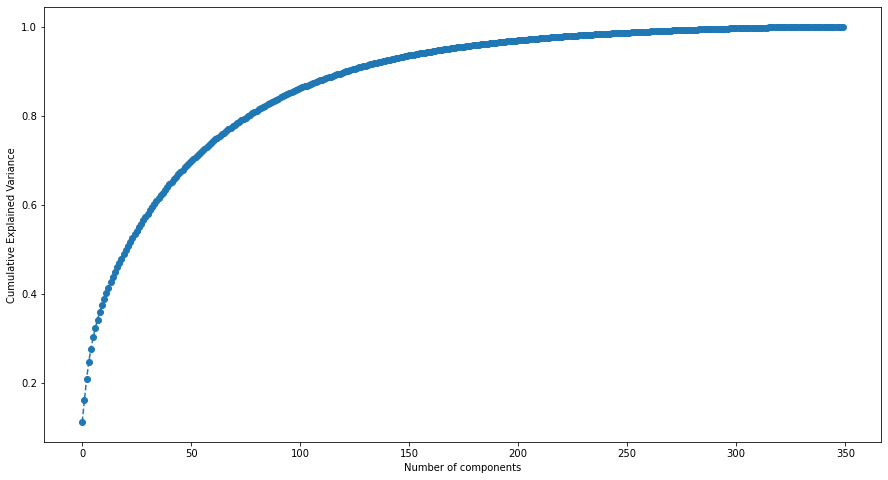

In [97]:
#--------------------------------------------------------------------------------------------Robust Scaler
az_rsc_pca = perform_pca(az_rsc, azdias)

10 components explain 0.3373941632212266 of variance.
20 components explain 0.4432029174344359 of variance.
30 components explain 0.513652932915443 of variance.
40 components explain 0.5666973793375343 of variance.
50 components explain 0.6103411603544119 of variance.
60 components explain 0.6474798937767071 of variance.
70 components explain 0.6793675755505096 of variance.
80 components explain 0.7082590959658471 of variance.
90 components explain 0.7345766503043226 of variance.
100 components explain 0.759271468569543 of variance.
110 components explain 0.7825292930413058 of variance.
120 components explain 0.8043990468289444 of variance.
130 components explain 0.8249445689601029 of variance.
140 components explain 0.8442879955611573 of variance.
150 components explain 0.8623961033464526 of variance.
160 components explain 0.8791557800755605 of variance.
170 components explain 0.8946647079748979 of variance.
180 components explain 0.9085715312736946 of variance.
190 components explai

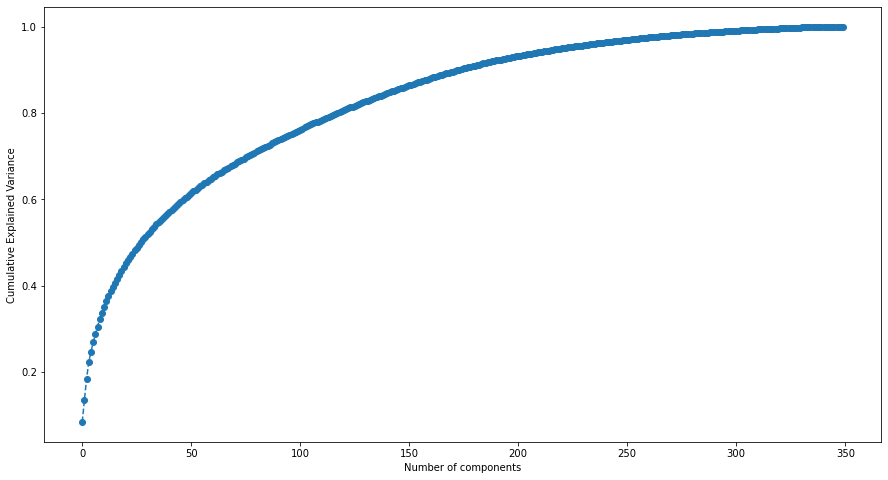

In [98]:
#--------------------------------------------------------------------------------------------Standard Scaler
az_sc_pca = perform_pca(az_sc, azdias)

10 components explain 0.39210129439634683 of variance.
20 components explain 0.49432117926261815 of variance.
30 components explain 0.5587574335439899 of variance.
40 components explain 0.6095206550515282 of variance.
50 components explain 0.6518364822137939 of variance.
60 components explain 0.6886933054032457 of variance.
70 components explain 0.720934929904388 of variance.
80 components explain 0.7498930695329721 of variance.
90 components explain 0.776401630605671 of variance.
100 components explain 0.8004015775869696 of variance.
110 components explain 0.8221206344554854 of variance.
120 components explain 0.8417407245942324 of variance.
130 components explain 0.8595267011740569 of variance.
140 components explain 0.8760863876449425 of variance.
150 components explain 0.891368179263349 of variance.
160 components explain 0.9052371393159756 of variance.
170 components explain 0.9176853341211862 of variance.
180 components explain 0.9286577675585198 of variance.
190 components expla

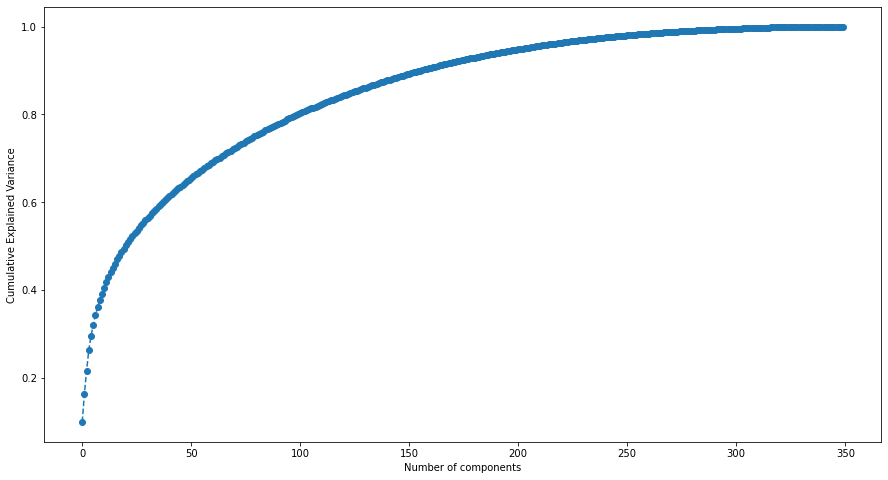

In [99]:
#--------------------------------------------------------------------------------------------MinMax Scaler
az_minmax_sc_pca = perform_pca(az_minmax_sc, azdias)


    RobustScaler -> 85% with 100 components
    StandardScaler -> 85% with 150 components
    MinMaxScaler -> 85% with 130 components


Let's calculate important features

In [100]:
def pca_df_generator(df_pca):
    
    index_lst = []
    for i in range(1,len(df_pca.components_)+1):
        temp_str = 'PC-'+str(i)
        index_lst.append(temp_str)
        
    pca_az_df = pd.DataFrame(df_pca.components_, columns=azdias.columns, index = index_lst)
    
    return pca_az_df

In [101]:
# comp = Number of PC components we want eg only PC-1 then 1 (int); PC-1 and PC-2 then 2
# imp = number of important features we want from that PC eg 5 for 5 important features
def imp_pca_feat(df, comp_number, imp):
    
    for i in range(comp_number):
        comp_num = i+1
        which_pc_str = "PC-"+str(comp_num)

        temp_df = df.iloc[comp_num-1:comp_num, :].sort_values(by=which_pc_str, axis=1, ascending=False)

        last_5_df = temp_df.iloc[:,-imp:]
        first_5_df = temp_df.iloc[:,:imp]

        pca_az_df = pd.concat([first_5_df, last_5_df], axis=1).T

        pca_az_df.plot(kind='bar', 
                          title='{} most important features and least important for PCA component {}'.format(imp, comp_num),
                          figsize=(12, 6))
        plt.show()

In [102]:
az_sc_pca_df = pca_df_generator(az_sc_pca)
az_rsc_pca_df = pca_df_generator(az_rsc_pca)
az_minmax_pca_df = pca_df_generator(az_minmax_sc_pca)

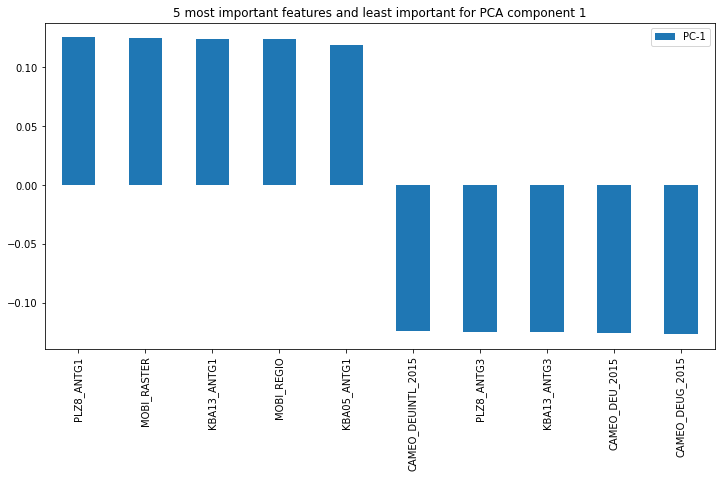

In [103]:
#--------------------------------------------------------------------------------------------------------Standard Scalar
imp_pca_feat(az_sc_pca_df, 1, 5)

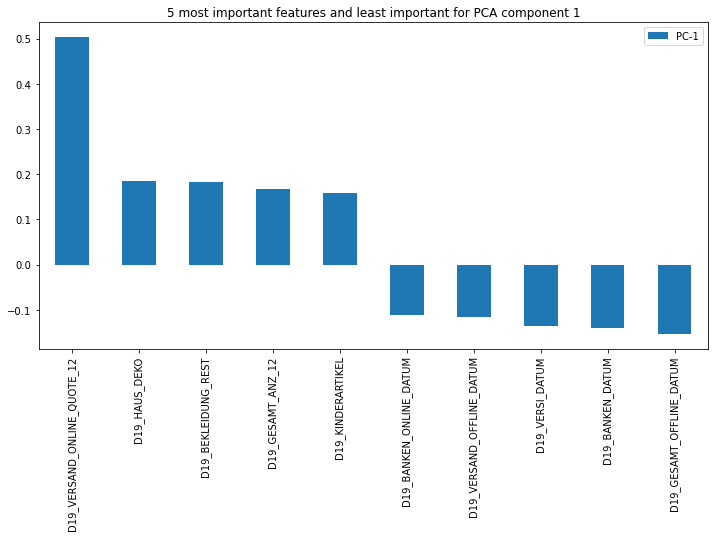

In [104]:
#--------------------------------------------------------------------------------------------Robust Scaler
imp_pca_feat(az_rsc_pca_df, 1, 5)

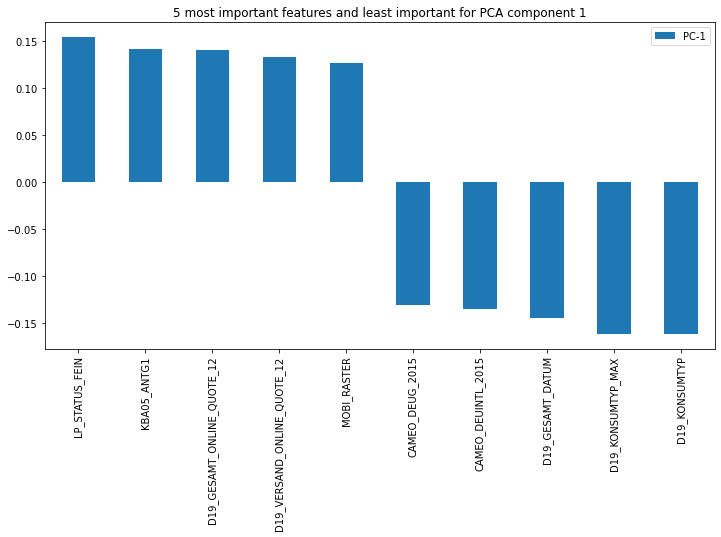

In [105]:
#--------------------------------------------------------------------------------------------MinMax Scaler
imp_pca_feat(az_minmax_pca_df, 1, 5)

Looking at the visualization and the number of components having data variance, we'll chose StandardScaler version with 150 components which has 85% of data.

We can change this later to check the if the model performs better.

In [107]:
pca = PCA(150)
az_sc_pca = pca.fit_transform(az_sc)

In [108]:
cus_sc_pca = pca.transform(cus_sc)

### Performing Clustering

In [110]:
wcss = []
for i in range(1,20):
    print("With clusters: "+str(i))
    kmeans_pca = KMeans(n_clusters=i, random_state=77)
    kmeans_pca.fit(az_sc_pca)
    wcss.append(kmeans_pca.inertia_)
    print("Done "+str(i))
    print()

With clusters: 1
Done 1

With clusters: 2
Done 2

With clusters: 3
Done 3

With clusters: 4
Done 4

With clusters: 5
Done 5

With clusters: 6
Done 6

With clusters: 7
Done 7

With clusters: 8
Done 8

With clusters: 9
Done 9

With clusters: 10
Done 10

With clusters: 11
Done 11

With clusters: 12
Done 12

With clusters: 13
Done 13

With clusters: 14
Done 14

With clusters: 15
Done 15

With clusters: 16
Done 16

With clusters: 17
Done 17

With clusters: 18
Done 18

With clusters: 19
Done 19



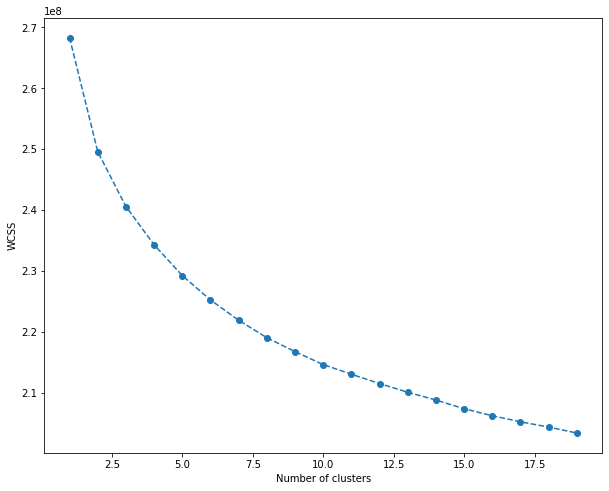

In [111]:
plt.figure(figsize = (10,8))
plt.plot(range(1,20), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [172]:
km_model = KMeans(n_clusters=9)
km_model.fit(az_sc_pca)

KMeans(n_clusters=9)

In [176]:
km_model_az = km_model.predict(az_sc_pca)
km_model_az

array([8, 4, 4, ..., 4, 5, 1])

In [177]:
km_model_cus = km_model.predict(cus_sc_pca)
km_model_cus

array([1, 2, 2, ..., 2, 6, 0])

In [178]:
def show_cluster_imp(arr, dataset_str):
    customer_class = pd.Series(arr).value_counts()

    class_customers = pd.DataFrame({'cluster': customer_class.index, '% of data': 100*customer_class.values/len(arr)})
    class_customers['data'] = dataset_str
    
    return class_customers

In [179]:
az_clusters = show_cluster_imp(km_model_az, 'population')
az_clusters

,cluster,% of data,data
0,0,14.173813,population
1,4,13.927746,population
2,1,13.787265,population
3,2,12.622010,population
4,5,11.246705,population
5,8,8.763146,population
6,7,8.583954,population
7,3,8.556239,population
8,6,8.339121,population


In [180]:
cus_clusters = show_cluster_imp(km_model_cus, 'customer')
cus_clusters

,cluster,% of data,data
0,8,23.753470,customer
1,1,14.731910,customer
2,0,13.991505,customer
3,7,12.676100,customer
4,2,12.630706,customer
5,6,6.926617,customer
6,5,6.612506,customer
7,4,5.106130,customer
8,3,3.571056,customer


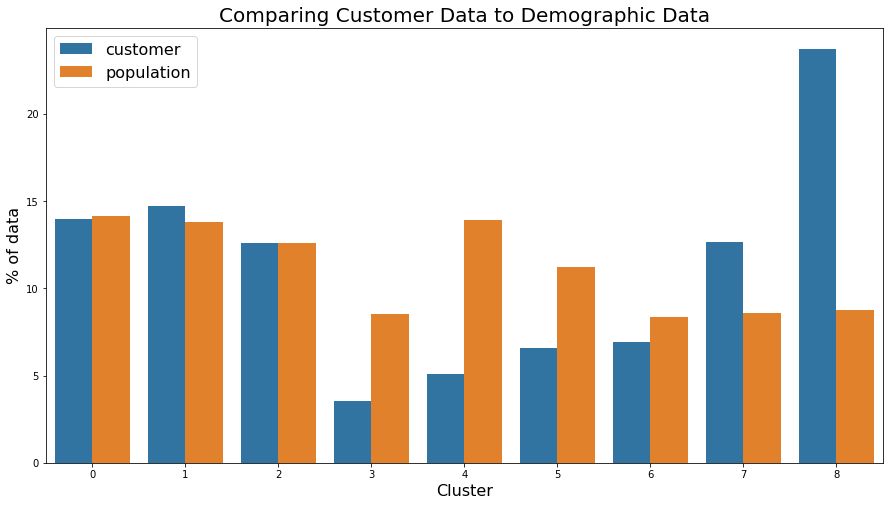

In [181]:
plt.figure(figsize=(15, 8))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([cus_clusters, az_clusters]))
plt.xlabel('Cluster', fontsize=16)
plt.ylabel('% of data', fontsize=16)
plt.title('Comparing Customer Data to Demographic Data', fontsize=20)
plt.legend(fontsize=16)
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [182]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error, log_loss, f1_score, precision_score, recall_score, r2_score

from tabulate import tabulate

In [350]:
mailout_train = pd.read_csv('./mailout_train.csv').drop(['Unnamed: 0'], axis=1)
mailout_train.head()

In [351]:
mailout_test = pd.read_csv('./mailout_test.csv').drop(['Unnamed: 0'], axis=1)
mailout_test.head()

In [185]:
# Response values
cout = mailout_train.RESPONSE.value_counts(dropna=False)
customer_response = pd.DataFrame({'RESPONSE': cout.index, '% of data': cout.values})
customer_response['% of data'] = 100*customer_response['% of data']/mailout_train.shape[0]

In [195]:
(mailout_train['RESPONSE'].value_counts()/mailout_train.shape[0] *100)

0    98.761696
1     1.238304
Name: RESPONSE, dtype: float64

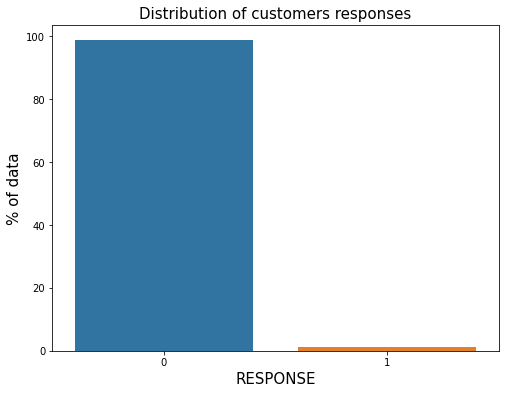

In [186]:
plt.figure(figsize=(8, 6))
sns.barplot(x="RESPONSE", y="% of data", data=customer_response)
plt.rc('xtick', labelsize=25)  
plt.rc('ytick', labelsize=25)
plt.xlabel('RESPONSE', fontsize=15)
plt.ylabel('% of data', fontsize=15)
plt.title('Distribution of customers responses', fontsize=15)
plt.show()

In [203]:
percentage_bins = [0,10,20,30,40,50,60,70,80,90,100]
percentage_nulls(percentage_bins, 0, mailout_train, 'columns')

42936 is the number of columns which has NaN entries more than or equal to 0% of total of 42962 entries
8770 is the number of columns which has NaN entries more than or equal to 10% of total of 42962 entries
8161 is the number of columns which has NaN entries more than or equal to 20% of total of 42962 entries
7962 is the number of columns which has NaN entries more than or equal to 30% of total of 42962 entries
7863 is the number of columns which has NaN entries more than or equal to 40% of total of 42962 entries
7862 is the number of columns which has NaN entries more than or equal to 50% of total of 42962 entries
7776 is the number of columns which has NaN entries more than or equal to 60% of total of 42962 entries
0 is the number of columns which has NaN entries more than or equal to 70% of total of 42962 entries
0 is the number of columns which has NaN entries more than or equal to 80% of total of 42962 entries
0 is the number of columns which has NaN entries more than or equal to

In [204]:
percentage_nulls(percentage_bins, 0, mailout_test, 'columns')

42813 is the number of columns which has NaN entries more than or equal to 0% of total of 42833 entries
8673 is the number of columns which has NaN entries more than or equal to 10% of total of 42833 entries
8033 is the number of columns which has NaN entries more than or equal to 20% of total of 42833 entries
7841 is the number of columns which has NaN entries more than or equal to 30% of total of 42833 entries
7723 is the number of columns which has NaN entries more than or equal to 40% of total of 42833 entries
7722 is the number of columns which has NaN entries more than or equal to 50% of total of 42833 entries
7627 is the number of columns which has NaN entries more than or equal to 60% of total of 42833 entries
1 is the number of columns which has NaN entries more than or equal to 70% of total of 42833 entries
0 is the number of columns which has NaN entries more than or equal to 80% of total of 42833 entries
0 is the number of columns which has NaN entries more than or equal to

## NOTE

As we can see that the dataset is highly imbalanced. We can deal with this in three ways

    1. Use AUC-ROC, F1 score, Recall score as our performance metrics
    2. Use tree-based classification algorithms
    3. Use Over-Sampling/Under-Sampling/SMOTE to balance the data
    
    
https://elitedatascience.com/imbalanced-classes

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

#### Splitting the dataset into features and target

In [352]:
mailout_train_clean = convert_datasets(mailout_train, df_desc, 10, 30, imputer)

In [275]:
y = mailout_train_clean[['RESPONSE']]
X = mailout_train_clean.drop(['RESPONSE'], axis=1)

In [276]:
X.shape, y.shape

((33836, 350), (33836, 1))

In [278]:
y['RESPONSE'].value_counts()

0.0    33420
1.0      416
Name: RESPONSE, dtype: int64

In [279]:
X_sc = StandardScaler().fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [281]:
X_rsc = RobustScaler().fit_transform(X)
X_rsc = pd.DataFrame(X_rsc, index=X.index, columns=X.columns)

In [282]:
X_msc = MinMaxScaler().fit_transform(X)
X_msc = pd.DataFrame(X_msc, index=X.index, columns=X.columns)

In [283]:
X_sc.shape, X_rsc.shape, X_msc.shape

((33836, 350), (33836, 350), (33836, 350))

In [353]:
mailout_test_clean = convert_datasets(mailout_test, df_desc, 10, 30, imputer)

In [354]:
mlts_sc = StandardScaler().fit_transform(mailout_test_clean)
mlts_sc = pd.DataFrame(mlts_sc, index=mailout_test_clean.index, columns=mailout_test_clean.columns)

mlts_sc.head()

In [286]:
mlts_sc.shape

(33818, 350)

In [288]:
# X_train_merged = pd.concat([X_train, y_train], axis=1)

#### SMOTE Function

In [289]:
# def ou_sample_data(x):
#     # Separate majority and minority classes
#     x_majority = x[x['RESPONSE']==0]
#     x_minority = x[x['RESPONSE']==1]
    
#     print("-"*40)
#     print("\n Up Sampling Start")
#     # Upsample minority class
#     x_upsampled = resample(x_minority,
#                             replace=True,
#                             n_samples=(int(x_majority.shape[0])),
#                             random_state=0)

#     # Combine majority class with upsampled minority class
#     upsampled = pd.concat([x_majority, x_upsampled])

#     # Display new class counts
#     print(upsampled['RESPONSE'].value_counts())
#     print("\n UpSampling Done")
#     print("-"*40)
    
    
#     print("-"*40)
#     print("\n Down Sampling Start")
#     # Downsample majority class
#     x_downsampled = resample(x_majority,
#                             replace=False,
#                             n_samples=(int(x_minority.shape[0])),
#                             random_state=0)

#     # Combine minority class with downsampled majority class
#     downsampled = pd.concat([x_downsampled, x_minority])

#     # Display new class counts
#     print(downsampled['RESPONSE'].value_counts())
#     print("\n Down Sampling Done")
#     print("-"*40)
    
    
#     print("-"*40)
#     print("\n MixUp Sampling Start")
#     # Upsample minority class
#     x_upsampled = resample(x_minority,
#                             replace=True,
#                             n_samples=(int(x_majority.shape[0]*0.5)),
#                             random_state=0)

#     # Combine majority class with upsampled minority class
#     mixupsampled = pd.concat([x_majority, x_upsampled])
    
    
#     x_up_majority = mixupsampled[mixupsampled['RESPONSE']==0]
#     x_up_minority = mixupsampled[mixupsampled['RESPONSE']==1]

#     print("-"*40)
#     print("\n Mixdown Sampling Start")
#     # Downsample majority class
#     x_mixed = resample(x_up_majority,
#                             replace=False,
#                             n_samples=(int(x_up_minority.shape[0])),
#                             random_state=0)

#     # Combine minority class with downsampled majority class
#     mixed = pd.concat([x_mixed, x_up_minority])

#     # Display new class counts
#     print(mixed['RESPONSE'].value_counts())
#     print("\n Mixed Sampling Done")
#     print("-"*40)

#     return upsampled, downsampled, mixed

In [290]:
# def smote_func():
    
#     kf = StratifiedKFold(n_splits=5)

#     for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
#         X_train = X.iloc[train_index]
#         y_train = y.iloc[train_index]['RESPONSE'].ravel()
#         X_test = X.iloc[test_index]
#         y_test = y.iloc[test_index]['RESPONSE'].ravel()
#         sm = SMOTE()
#         X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
        
#         model.fit(X_train_oversampled, y_train_oversampled)
        
#         print(f'For fold {fold}:')
#         print_metrics(model, X_test, y_test, model_name)

In [291]:
# train_ups, train_downs, train_mix = ou_sample_data(X_train_merged)

In [292]:
# y_ups = train_ups[['RESPONSE']]
# X_ups = train_ups.drop(['RESPONSE'], axis=1)

# y_downs = train_downs[['RESPONSE']]
# X_downs = train_downs.drop(['RESPONSE'], axis=1)

# y_mix = train_mix[['RESPONSE']]
# X_mix = train_mix.drop(['RESPONSE'], axis=1)

### Splitting the datasets

In [293]:
ts = 0.1

X_sc_train, X_sc_test, y_sc_train, y_sc_test = train_test_split(X_sc, y, test_size=ts, random_state =0, shuffle=True)
X_rsc_train, X_rsc_test, y_rsc_train, y_rsc_test = train_test_split(X_rsc, y, test_size=ts, random_state =0, shuffle=True)
X_msc_train, X_msc_test, y_msc_train, y_msc_test = train_test_split(X_msc, y, test_size=ts, random_state =0, shuffle=True)

curr_xy_train = {
    'sc':(X_sc_train, y_sc_train),
#     'rsc':(X_rsc_train, y_rsc_train),
    'msc':(X_msc_train, y_msc_train)
}

curr_xy_test = {
    'sc':(X_sc_test, y_sc_test),
#     'rsc':(X_rsc_test, y_rsc_test),
    'msc':(X_msc_test, y_msc_test)
}

#### Choosing a Baseline Model

We'll choose RandomForestClassifier as our baseline model and compare our score with other models

The other models we'll choose are:
       1. GradientBoostingClassifier
       2. AdaBoostClassifier
       3. Logistic Regression
       4. Nearest Centroid
       5. XGBoost Classifier

#### Making a function for Model Evaluation

In [324]:
def print_metrics(model, X_test, y_test, model_name):
    print('\n' + model_name + ' performance on the test data set:')
    
    y_pred  = model.predict(X_test)
    
    accuracy_test   = accuracy_score(y_test, y_pred)
#     F1_test         = f1_score(y_test, y_pred)
#     precision_test  = precision_score(y_test, y_pred, average='binary')
#     recall_test     = recall_score(y_test, y_pred, average='binary')

    model_probs = model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, model_probs)
    false_positive, true_positive, _ = roc_curve(y_test, model_probs)

    
    header = ["Metric", "Test"]
    table  = [
               ["accuracy",  accuracy_test],
#                ["precision", precision_test],
#                ["recall",    recall_test],
#                ["F1",        F1_test],
               ["AUC",       auc_test]
             ]

    print(tabulate(table, header, tablefmt="fancy_grid"))
    
    print('\n' + model_name + ' ROC plot')
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label=model_name)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.2f)' % auc_test)
    plt.legend(loc='best')
    plt.show()

In [321]:
def plot_importance_feat(best_model, feature_col, top_n):
    feature_imp = best_model.feature_importances_
    
    sorted_feature_columns = {feature_col[i]:round(feature_imp[i],3) for i in np.argsort(feature_imp)}
    
    top_n_features = dict(list(sorted_feature_columns.items())[-top_n:])
    
    plt.figure(figsize = (13,5))
    plt.barh(range(len(top_n_features)), top_n_features.values(), align='center', color='green', ecolor='black', height=0.5)
    plt.yticks(range(len(top_n_features)), top_n_features.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.title('Predictor Importance', fontsize=20)
    plt.show()

## Using RandomForestClassification

----------------------------------------
sc
---------------------------------------- 


Random_Forest_Classifier_sc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.815109 │
╘══════════╧══════════╛

Random_Forest_Classifier_sc ROC plot


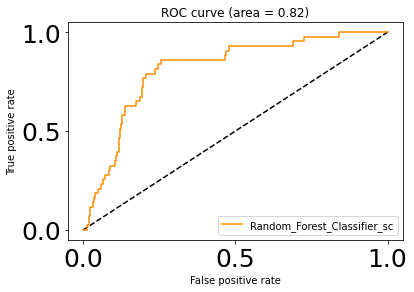

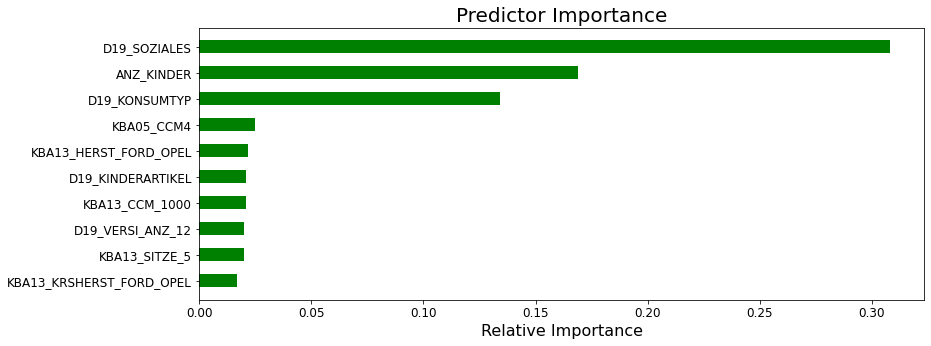

---------------------------------------------------------------------------------------------------- 

----------------------------------------
msc
---------------------------------------- 



In [ ]:
for k,v in curr_xy_train.items():
    print("-"*40)
    print(str(k))
    print("-"*40,"\n")
    
    model_name = 'Random_Forest_Classifier_'+k
    model = RandomForestClassifier(random_state=42, criterion='gini', max_depth=5, n_estimators=500, max_features='auto')
    
    curr_X_train, curr_Y_train = curr_xy_train[k]
    curr_X_test, curr_Y_test = curr_xy_test[k]
    
    model.fit(curr_X_train, curr_Y_train.values.ravel())
    
    print_metrics(model, curr_X_test, curr_Y_test.values.ravel(), model_name)
    plot_importance_feat(gb_clf, curr_X_test.columns, 10)
    
    model_probs = model.predict_proba(curr_X_test)[:, 1]
    auc_test = roc_auc_score(curr_Y_test, model_probs)    
    model_name = model_name+'_'+str(auc_test)
#     result_csv(model, model_name, mlts_sc)
    
    del model_name, model, auc_test, model_probs
    
    print("-"*100,"\n")

In [355]:
n_estimators = [300,500,700]
max_depth = [2,7,11]
bootstrap = [False]

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1)
gs.fit(X_sc_train, y_sc_train)

In [ ]:
gs.best_estimator_

In [ ]:
gs.best_params_

## Using Logistic Regression

----------------------------------------
sc
---------------------------------------- 


Logistic_Regression_sc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.757335 │
╘══════════╧══════════╛

Logistic_Regression_sc ROC plot


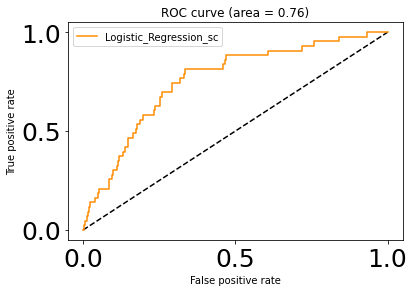

---------------------------------------------------------------------------------------------------- 

----------------------------------------
msc
---------------------------------------- 


Logistic_Regression_msc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.76298  │
╘══════════╧══════════╛

Logistic_Regression_msc ROC plot


C:\Users\bune1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


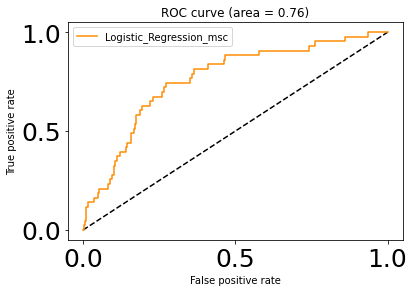

---------------------------------------------------------------------------------------------------- 



In [327]:
for k,v in curr_xy_train.items():
    print("-"*40)
    print(str(k))
    print("-"*40,"\n")
    
    model_name = 'Logistic_Regression_' + k
    model = LogisticRegression(max_iter=300)
    
    curr_X_train, curr_Y_train = curr_xy_train[k]
    curr_X_test, curr_Y_test = curr_xy_test[k]    
    
    model.fit(curr_X_train, curr_Y_train.values.ravel())
    
    print_metrics(model, curr_X_test, curr_Y_test.values.ravel(), model_name)
#     plot_importance_feat(gb_clf, curr_X_test.columns, 10)
    
    model_probs = model.predict_proba(curr_X_test)[:, 1]
    auc_test = roc_auc_score(curr_Y_test, model_probs)    
    model_name = model_name+'_'+str(auc_test)  
#     result_csv(model, model_name, mlts_sc)
    
    print("-"*100,"\n")

## Using GradientBoosting

----------------------------------------
sc
---------------------------------------- 


Gradient_Boosting_sc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.763342 │
╘══════════╧══════════╛

Gradient_Boosting_sc ROC plot


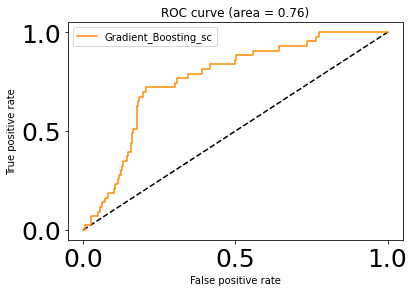

----------------------------------------
Making prediction
----------------------------------------
----------------------------------------
Copying main dataframe
----------------------------------------
----------------------------------------
Saving response
----------------------------------------
----------------------------------------
Dropping rest columns
----------------------------------------
----------------------------------------
Saving to csv
----------------------------------------


----------------------------------------
DONE
----------------------------------------
---------------------------------------------------------------------------------------------------- 

----------------------------------------
msc
---------------------------------------- 


Gradient_Boosting_msc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.763342 │
╘══════════╧════

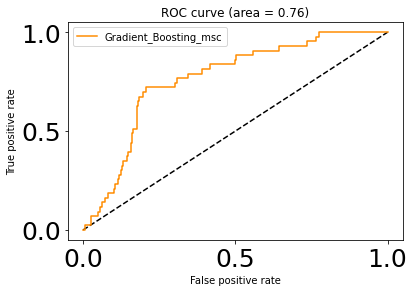

----------------------------------------
Making prediction
----------------------------------------
----------------------------------------
Copying main dataframe
----------------------------------------
----------------------------------------
Saving response
----------------------------------------
----------------------------------------
Dropping rest columns
----------------------------------------
----------------------------------------
Saving to csv
----------------------------------------


----------------------------------------
DONE
----------------------------------------
---------------------------------------------------------------------------------------------------- 



In [328]:
for k,v in curr_xy_train.items():
    print("-"*40)
    print(str(k))
    print("-"*40,"\n")
    
    model_name = 'Gradient_Boosting_'+k
    model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
    
    curr_X_train, curr_Y_train = curr_xy_train[k]
    curr_X_test, curr_Y_test = curr_xy_test[k]    
    
    model.fit(curr_X_train, curr_Y_train.values.ravel())
    
    print_metrics(model, curr_X_test, curr_Y_test.values.ravel(), model_name)
#     plot_importance_feat(gb_clf, curr_X_test.columns, 10)
    
    model_probs = model.predict_proba(curr_X_test)[:, 1]
    auc_test = roc_auc_score(curr_Y_test, model_probs)    
    model_name = model_name+'_'+str(auc_test)  
#     result_csv(model, model_name, mlts_sc)
    
    print("-"*100,"\n")

## Using XGB

----------------------------------------
sc
---------------------------------------- 


XGB_sc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.771082 │
╘══════════╧══════════╛

XGB_sc ROC plot


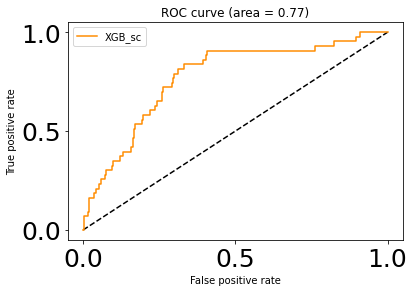

---------------------------------------------------------------------------------------------------- 

----------------------------------------
msc
---------------------------------------- 


XGB_msc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.771082 │
╘══════════╧══════════╛

XGB_msc ROC plot


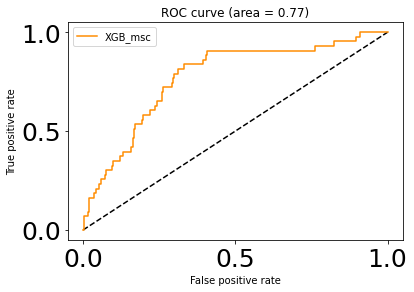

---------------------------------------------------------------------------------------------------- 



In [329]:
for k,v in curr_xy_train.items():
    print("-"*40)
    print(str(k))
    print("-"*40,"\n")
    
    model_name = 'XGB_'+k
    model = XGBClassifier()
    
    curr_X_train, curr_Y_train = curr_xy_train[k]
    curr_X_test, curr_Y_test = curr_xy_test[k]    
    
    model.fit(curr_X_train, curr_Y_train.values.ravel())
    
    print_metrics(model, curr_X_test, curr_Y_test.values.ravel(), model_name)
#     plot_importance_feat(gb_clf, curr_X_test.columns, 10)
    
    model_probs = model.predict_proba(curr_X_test)[:, 1]
    auc_test = roc_auc_score(curr_Y_test, model_probs)    
    model_name = model_name+'_'+str(auc_test)
#     result_csv(model, model_name, mlts_sc)
    
    del model_name, model, auc_test, model_probs
    
    print("-"*100,"\n")

## LGBM Classifier

----------------------------------------
sc
---------------------------------------- 


LGBM_sc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.788728 │
╘══════════╧══════════╛

LGBM_sc ROC plot


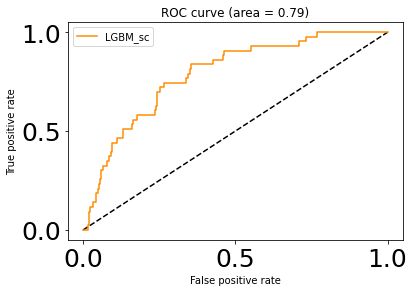

---------------------------------------------------------------------------------------------------- 

----------------------------------------
msc
---------------------------------------- 


LGBM_msc performance on the test data set:
╒══════════╤══════════╕
│ Metric   │     Test │
╞══════════╪══════════╡
│ accuracy │ 0.987293 │
├──────────┼──────────┤
│ AUC      │ 0.778315 │
╘══════════╧══════════╛

LGBM_msc ROC plot


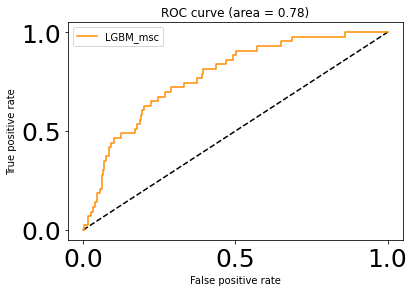

---------------------------------------------------------------------------------------------------- 



In [330]:
for k,v in curr_xy_train.items():
    print("-"*40)
    print(str(k))
    print("-"*40,"\n")
    
    model_name = 'LGBM_'+k
    model = LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, n_estimators=300, 
                                bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)
    
    curr_X_train, curr_Y_train = curr_xy_train[k]
    curr_X_test, curr_Y_test = curr_xy_test[k]    
    
    model.fit(curr_X_train, curr_Y_train.values.ravel())
    
    print_metrics(model, curr_X_test, curr_Y_test.values.ravel(), model_name)
#     plot_importance_feat(gb_clf, curr_X_test.columns, 10)
    
    model_probs = model.predict_proba(curr_X_test)[:, 1]
    auc_test = roc_auc_score(curr_Y_test, model_probs)    
    model_name = model_name+'_'+str(auc_test)
#     result_csv(model, model_name, mlts_sc)
    
    del model_name, model, auc_test, model_probs
    
    print("-"*100,"\n")

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [302]:
def result_csv(model, model_name_str, df_to_predict):
    print("-"*40)
    print("Making prediction")
    pred = model.predict(df_to_predict)
    predictions = model.predict_proba(df_to_predict)[:, 1]
    print("-"*40)        
    
    print("-"*40)
    print("Copying main dataframe")
    result = df_to_predict.copy()
    print("-"*40)

    print("-"*40)
    print("Saving response")
    result['RESPONSE'] = predictions
    print("-"*40)

    print("-"*40)
    print("Dropping rest columns")
    result.drop(list(df_to_predict.columns), axis=1, inplace=True)
    print("-"*40)

    print("-"*40)
    print("Saving to csv")
    csv_loc = './pred/'+model_name_str+'_result.csv'
    result.to_csv(csv_loc)
    print("-"*40)
        
    print("\n")
    print("-"*40)
    print("DONE")
    print("-"*40)
    
    return